##**Методы машинного обучения для оценки содержания азота в растениях по аэрофотоснимкам**

Этот блокнот предназначен для генерации обучающих данных. Папка dataset содержит сырые изображения, необходимо конвертировать их в numpy-массив для более удобной загрузки данных. Также в этом блокноте при помощи простого алгоритма создаются синтетические изображения, которые также конвертируются в numpy-массивы. Таким образом, в дальнейшем в файлах с обучением моделей достаточно просто обратно подгрузить эти данные.

**Подключение данных из гитхаб-репозитория**

In [ ]:
!git clone https://github.com/villerbond/nytrogen-status-analysis

**Подключение всех необходимых библиотек**

In [5]:
import os
from tqdm import tqdm

In [26]:
train_dataset_dir = 'nytrogen-status-analysis/dataset/raw/train/'
test_dataset_dir = 'nytrogen-status-analysis/dataset/raw/test/'

In [35]:
def collect_data(root_dir):
  """
    Собирает пути к изображениям и маскам из указанной директории.

    Аргументы:
    root_dir - корневая папка, содержащая спектральные изображения и маски.

    Возвращает:
    images - список словарей, где ключи — спектральные каналы ('RGB', 'NDVI' и т. д.),
             а значения — пути к соответствующим изображениям
    masks - список путей к файлам масок.
  """
  images = []  # Список для хранения словарей с путями к изображениям в разных каналах
  masks = []   # Список для хранения путей к маскам

  # Пути до папок с изображениями в разных каналах и с соответствующими масками
  spectra_dirs = ["NDVI", "NearIR", "RedEdge", "RGB"]
  spectra_paths = {spectrum: os.path.join(root_dir, spectrum) for spectrum in spectra_dirs}
  masks_dir = os.path.join(root_dir, "Mask")

  # Проверка существования папок
  for spectrum, path in spectra_paths.items():
    if not os.path.exists(path):
      raise FileNotFoundError(f"Папка с каналом {spectrum} не найдена: {path}")
  if not os.path.exists(masks_dir):
    raise FileNotFoundError(f"Папка с масками не найдена: {masks_dir}")

  # Получение списка файлов (изображений) из каждой папки
  mask_files = sorted(os.listdir(masks_dir))
  spectra_files = {spectrum: sorted(os.listdir(spectra_paths[spectrum])) for spectrum in spectra_dirs}

  # Добавление путей до изображений в массивы
  for i, mask_file in tqdm(enumerate(mask_files), total=len(mask_files), desc="Collecting"):
    entry = {}

    for spectrum in spectra_dirs:
      spectrum_path = spectra_paths[spectrum]
      spectrum_files_list = spectra_files[spectrum]
      if i < len(spectrum_files_list):
        entry[spectrum] = os.path.join(spectrum_path, spectrum_files_list[i])

    if entry:
      images.append(entry)
      masks.append(os.path.join(masks_dir, mask_file))

  return images, masks

In [38]:
train_images_paths, train_masks_paths = collect_data(train_dataset_dir)
test_images_paths, test_masks_paths = collect_data(test_dataset_dir)

print(f"\nРазмер тренировочного датасета: {len(train_images_paths)} изображений и {len(train_masks_paths)} масок")
print(f"Размер тестового датасета: {len(test_images_paths)} изображений и {len(test_masks_paths)} масок")

Collecting: 100%|██████████| 66/66 [00:00<00:00, 61860.13it/s]


Размер тренировочного датасета: 66 изображений и 66 масок
Размер тестового датасета: 66 изображений и 66 масок


In [39]:
import numpy as np
from tqdm import tqdm
from PIL import Image

def make_nparrays(images, masks):
    """
    Преобразует списки путей к изображениям и маскам в NumPy-массивы.

    Аргументы:
    images - список словарей, где ключи — спектральные диапазоны ('RGB', 'NDVI' и т. д.),
             а значения — пути к соответствующим изображениям.
    masks - список путей к файлам масок.

    Возвращает:
    X_data - массив изображений (количество каналов зависит от данных)
    y_data - массив сегментационных масок
    """

    X_data = []  # Массив изображений
    y_data = []  # Массив масок

    for image_paths, mask_path in tqdm(zip(images, masks), total=len(masks), desc='Processing data'):

        channels = []

        # Открываем и обрабатываем изображения разных спектров
        for spectrum, path in image_paths.items():
            img = Image.open(path)  # Загружаем изображение
            img = np.array(img) / 255.0  # Нормализуем значения пикселей в диапазон [0, 1]

            # Если канал не RGB, преобразуем его в формат (128, 128, 1), добавляя измерение глубины
            if spectrum != 'RGB':
                img = img.reshape((128, 128, 1))

            channels.append(img)  # Добавляем канал в список

        # Объединяем все спектральные каналы по последней оси (создаем многоканальное изображение)
        image = np.concatenate(channels, axis=-1)

        # Загружаем и обрабатываем маску
        mask = Image.open(mask_path)
        mask = np.array(mask)

        masks = [] # Список для хранения бинарных масок по классам

        # Разделяем маску на 6 классов по пороговым значениям
        for i in [0, 40, 80, 120, 160, 200]:
            cls_mask = (mask == i)  # Создаем бинарную маску для каждого класса
            masks.append(cls_mask)

        # Объединяем все бинарные маски в один массив (кол-во классов, H, W)
        masks = np.stack(masks, axis=0)

        # Преобразуем маску в формат (H, W, 1), где в каждом пикселе записан номер класса
        mask = np.argmax(masks, axis=0)
        mask = np.expand_dims(mask, axis=-1)

        # Добавляем обработанные данные в списки
        X_data.append(image)
        y_data.append(mask)

    # Преобразуем списки в NumPy-массивы
    return np.array(X_data), np.array(y_data, dtype=np.uint8)


In [43]:
train_images, train_masks = make_nparrays(train_images_paths, train_masks_paths)
test_images, test_masks = make_nparrays(test_images_paths, test_masks_paths)
print(f"\nРазмер массива тренировочных изображений: {train_images.shape}\nРазмер массива тренировочных масок: {train_masks.shape}")
print(f"Размер массива тестовых изображений: {test_images.shape}\nРазмер массива тестовых масок: {test_masks.shape}")

Processing data: 100%|██████████| 66/66 [00:00<00:00, 112.43it/s]


Размер массива тренировочных изображений: (66, 128, 128, 6)
Размер массива тренировочных масок: (66, 128, 128, 1)
Размер массива тестовых изображений: (66, 128, 128, 6)
Размер массива тестовых масок: (66, 128, 128, 1)


Размер: (N, H, W, C), где

N - количество изображений,

H x W - размер изображения в пикселах

C - количество каналов (для обычных изображений шесть, три на RGB и по одному для NearIR, NDVI, RedEdge; для масок только один канал с классами)

In [ ]:
np.savez("nytrogen-status-analysis/dataset/train_images_and_masks.npz", train_images=train_images, train_masks=train_masks)
np.savez("nytrogen-status-analysis/dataset/test_images_and_masks.npz", test_images=train_images, test_masks=train_masks)

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 15.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm

from PIL import Image
import os
import numpy as np
import random
import cv2

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.data import Dataset, DataLoader, ConcatDataset

from torchmetrics import JaccardIndex

from torch.optim.lr_scheduler import ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

In [ ]:
orig_dataset_dir = '/content/drive/MyDrive/dataset/original'
synth_dataset_dir = '/content/drive/MyDrive/dataset/synthetic'
test_dataset_dir = '/content/drive/MyDrive/dataset/test_half'

In [ ]:
def collect_images_and_masks(root_dir):
  images = []
  masks = []

  for field in os.listdir(root_dir):

    field_path = os.path.join(root_dir, field)
    if os.path.isdir(field_path):

      for training in os.listdir(field_path):

        training_path = os.path.join(field_path, training)
        if os.path.isdir(training_path):

          for test_area in os.listdir(training_path):

            test_area_path = os.path.join(training_path, test_area)
            if os.path.isdir(test_area_path):

              mask_dir = os.path.join(test_area_path, "Mask")
              if os.path.exists(mask_dir):

                mask_files = sorted(os.listdir(mask_dir))
                spectra_dirs = ["NDVI", "NearIR", "RedEdge", "RGB"]
                spectra_files = {spectrum: [] for spectrum in spectra_dirs}

                for spectrum in spectra_dirs:
                  spectrum_dir = os.path.join(test_area_path, spectrum)
                  if os.path.exists(spectrum_dir):
                    spectra_files[spectrum] = sorted(os.listdir(spectrum_dir))

                for i, mask_file in enumerate(mask_files):
                  entry = {}
                  for spectrum in spectra_dirs:
                    if i < len(spectra_files[spectrum]):
                      entry[spectrum]  = os.path.join(test_area_path, spectrum, spectra_files[spectrum][i])

                  if entry:
                    images.append(entry)
                    masks.append(os.path.join(mask_dir, mask_file))

  return images, masks

In [ ]:
def collect_data(root_dir):
  images = []
  masks = []

  spectra_dirs = ["NDVI", "NearIR", "RGB"]
  spectra_paths = {spectrum: os.path.join(root_dir, spectrum) for spectrum in spectra_dirs}
  masks_dir = os.path.join(root_dir, "Masks")

  for spectrum, path in spectra_paths.items():
    if not os.path.exists(path):
      raise FileNotFoundError(f"Папка с каналом {spectrum} не найдена: {path}")
  if not os.path.exists(masks_dir):
    raise FileNotFoundError(f"Папка с масками не найдена: {masks_dir}")

  mask_files = sorted(os.listdir(masks_dir))
  spectra_files = {spectrum: sorted(os.listdir(spectra_paths[spectrum])) for spectrum in spectra_dirs}

  for i, mask_file in tqdm(enumerate(mask_files), total=len(mask_files), desc="Collecting"):
    entry = {}

    for spectrum in spectra_dirs:
      spectrum_path = spectra_paths[spectrum]
      spectrum_files_list = spectra_files[spectrum]
      if i < len(spectrum_files_list):
        entry[spectrum] = os.path.join(spectrum_path, spectrum_files_list[i])

    if entry:
      images.append(entry)
      masks.append(os.path.join(masks_dir, mask_file))

  return images, masks

In [ ]:
images, masks = collect_images_and_masks(orig_dataset_dir)

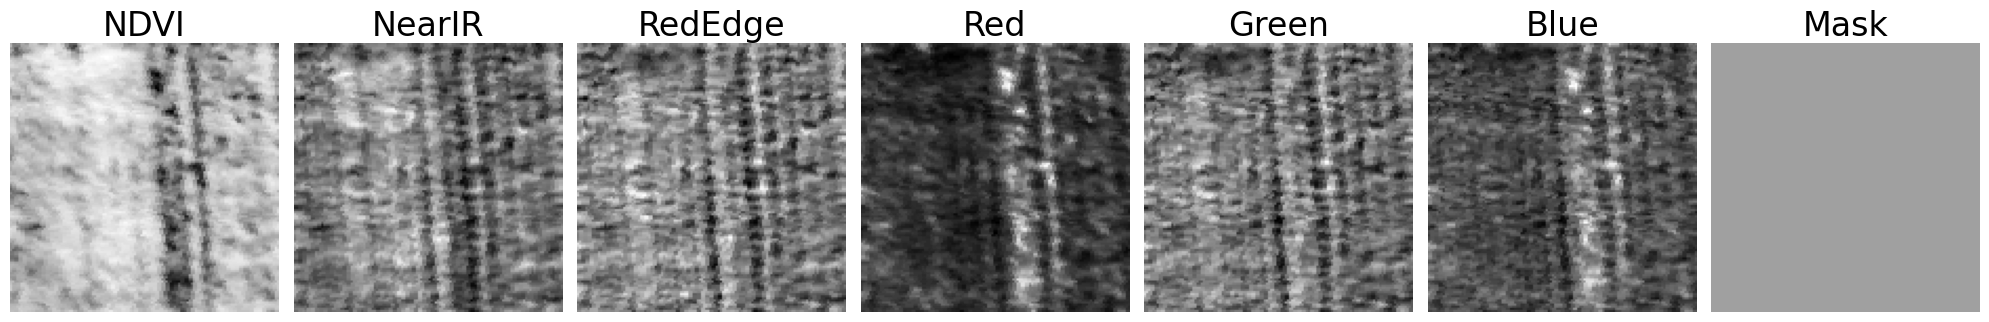

In [ ]:
ind = random.randint(0, len(images) - 1)
image_path = images[ind]
mask_path = masks[ind]

channels = {}
for spectrum, path in image_path.items():
  if spectrum == "RGB":
    rgb_image = Image.open(path)
    r, g, b = rgb_image.split()
    channels["Red"] = r
    channels["Green"] = g
    channels["Blue"] = b
  else:
    image = Image.open(path)
    channels[spectrum] = image

mask = Image.open(mask_path).convert("RGB")
num_spectra = len(channels)

fig, axes = plt.subplots(1, num_spectra + 1, figsize=(20, 5))
for i, (spectrum, image) in enumerate(channels.items()):
  axes[i].imshow(image, cmap="gray")
  axes[i].set_title(spectrum, fontsize=24)  # Увеличение размера шрифта
  axes[i].axis("Off")

axes[-1].imshow(mask, cmap="gray")
axes[-1].set_title("Mask", fontsize=24)  # Увеличение размера шрифта
axes[-1].axis("Off")

plt.tight_layout()
plt.show()

In [ ]:
indices = list(range(len(images)))
random.shuffle(indices)
images = [images[i] for i in indices]
masks = [masks[i] for i in indices]

In [ ]:
labels = {
    0: '0 kg/ha',
    1: '40 kg/ha',
    2: '60 kg/ha',
    3: '80 kg/ha',
    4: '120 kg/ha',
    5: '200 kg/ha'
}

labels_arr = ['0 kg/ha', '40 kg/ha', '60 kg/ha', '80 kg/ha', '120 kg/ha', '200 kg/ha']

In [ ]:
# def split_data(images, masks, ratio=0.2):
#   dataset_size = len(images)
#   test_size = int(dataset_size * ratio)
#   indices = list(range(dataset_size))
#   random.shuffle(indices)

#   test_indices = indices[:test_size]
#   train_indices = indices[test_size:]

#   test_images = [images[i] for i in test_indices]
#   test_masks = [masks[i] for i in test_indices]

#   train_images = [images[i] for i in train_indices]
#   train_masks = [masks[i] for i in train_indices]

#   return train_images, train_masks, test_images, test_masks

In [ ]:
def make_nparrays(images, masks):
  X_data = []
  y_data = []

  for image_paths, mask_path in tqdm(zip(images, masks), total=len(masks), desc='Processing data'):

    channels = []
    for spectrum, path in image_paths.items():
      img = Image.open(path)
      img = np.array(img) / 255.0
      if (spectrum != 'RGB'):
        img = img.reshape((128, 128, 1))
      channels.append(img)
    image = np.concatenate(channels, axis=-1)

    mask = Image.open(mask_path)
    mask = np.array(mask)

    masks = []
    for i in [0, 40, 80, 120, 160, 200]:
      cls_mask = (mask == i)
      masks.append(cls_mask)
    masks = np.stack(masks, axis=0)
    mask = np.argmax(masks, axis=0)
    mask = np.expand_dims(mask, axis=-1)

    X_data.append(image)
    y_data.append(mask)

  return np.array(X_data), np.array(y_data, dtype=np.uint8)

In [ ]:
images_arr, masks_arr = make_nparrays(images, masks)

Processing data: 100%|██████████| 132/132 [04:16<00:00,  1.94s/it]


In [ ]:
images_arr.shape, masks_arr.shape

((132, 128, 128, 6), (132, 128, 128, 1))

In [ ]:
# images_arr = images_arr.transpose(0, 3, 1, 2)
# images_arr.shape, masks_arr.shape

((132, 6, 128, 128), (132, 128, 128, 1))

In [ ]:
indices = np.random.permutation(len(images_arr))
images_arr = images_arr[indices]
masks_arr = masks_arr[indices]

In [ ]:
size = images_arr.shape[0]
test_size = int(size * 0.4)
train_size = size - test_size
train_images_arr = images_arr[:train_size]
train_masks_arr = masks_arr[:train_size]
test_images_arr = images_arr[train_size:]
test_masks_arr = masks_arr[train_size:]
print(train_images_arr.shape, train_masks_arr.shape)
print(test_images_arr.shape, test_masks_arr.shape)

(80, 128, 128, 6) (80, 128, 128, 1)
(52, 128, 128, 6) (52, 128, 128, 1)


In [ ]:
test_images_arr = test_images_arr.transpose(0, 3, 1, 2)
test_masks_arr = test_masks_arr.squeeze(axis=-1)
print(test_images_arr.shape, test_masks_arr.shape)

(52, 6, 128, 128) (52, 128, 128)


In [ ]:
classes = [0, 0, 0, 0, 0, 0]
for el in test_masks_arr:
  classes[el[0][0]] += 1
print(classes)

[7, 7, 12, 9, 9, 8]


In [ ]:
# def generate_synthetic_data(images, masks, N):
#   images = images.transpose(0, 3, 1, 2)
#   n, num_channels, h, w = images.shape
#   generated_images = []
#   generated_masks = []

#   for i in range(N):
#     base_idx = random.randint(0, n - 1)
#     base_image = images[base_idx].copy()
#     base_mask = masks[base_idx].copy()
#     base_mask = base_mask.squeeze(axis=-1)
#     new_img = base_image.copy()
#     new_mask = base_mask.copy()

#     num_sources = random.randint(0, 6)
#     source_inds = np.random.choice([i for i in range(n) if i != base_idx], size=num_sources, replace=False)

#     for ind in source_inds:
#       img = images[ind]
#       mask = masks[ind]
#       mask = mask.squeeze(axis=-1)

#       spot_mask = np.zeros((h, w), dtype=np.uint8)

#       for _ in range(random.randint(3, 8)):  # Количество пятен на изображение
#         center = (random.randint(0, w - 1), random.randint(0, h - 1))
#         axes = (random.randint(h // 32, h // 8), random.randint(h // 32, h // 8))
#         angle = random.randint(0, 360)
#         cv2.ellipse(spot_mask, center, axes, angle, 0, 360, 1, -1)

#       spot_mask = cv2.GaussianBlur(spot_mask.astype(np.float32), (15, 15), 5)
#       spot_mask = (spot_mask > 0.2).astype(np.uint8)  # Бинаризация

#       for c in range(num_channels):
#         new_img[c] = np.where(spot_mask, img[c], new_img[c])
#         new_mask = np.where(spot_mask, mask, new_mask)

#     generated_images.append(new_img)
#     generated_masks.append(new_mask)

#   return np.array(generated_images), np.array(generated_masks)

In [ ]:
def generate_synthetic_data(images, masks, N):
    images = images.transpose(0, 3, 1, 2)  # Перестановка каналов
    n, num_channels, h, w = images.shape
    generated_images = []
    generated_masks = []

    for i in range(N):
        base_idx = random.randint(0, n - 1)
        base_image = images[base_idx].copy()
        base_mask = masks[base_idx].copy()
        base_mask = base_mask.squeeze(axis=-1)

        new_img = base_image.copy()
        new_mask = base_mask.copy()

        num_sources = random.randint(1, 6)
        source_inds = np.random.choice([i for i in range(n) if i != base_idx], size=num_sources, replace=False)

        for ind in source_inds:
            img = images[ind]
            mask = masks[ind]
            mask = mask.squeeze(axis=-1)

            spot_mask = np.zeros((h, w), dtype=np.uint8)

            for _ in range(random.randint(3, 8)):  # Количество пятен на изображение
                # Генерация случайного прямоугольника с более равномерным распределением
                rect_w = random.randint(w // 16, w // 4)
                rect_h = random.randint(h // 16, h // 4)

                # Смещение положения в любую часть изображения
                x1 = random.randint(0, w - rect_w)  # Левый верхний угол по ширине
                y1 = random.randint(0, h - rect_h)  # Левый верхний угол по высоте
                x2 = x1 + rect_w
                y2 = y1 + rect_h

                # Добавляем случайные неровности к углам
                shift_range = max(rect_w, rect_h) // 10
                points = np.array([
                    [x1 + random.randint(-shift_range, shift_range), y1 + random.randint(-shift_range, shift_range)],
                    [x2 + random.randint(-shift_range, shift_range), y1 + random.randint(-shift_range, shift_range)],
                    [x2 + random.randint(-shift_range, shift_range), y2 + random.randint(-shift_range, shift_range)],
                    [x1 + random.randint(-shift_range, shift_range), y2 + random.randint(-shift_range, shift_range)]
                ], dtype=np.int32)

                # Рисуем многоугольник
                cv2.fillPoly(spot_mask, [points], 1)

            # Размываем для мягких краев
            spot_mask = cv2.GaussianBlur(spot_mask.astype(np.float32), (11, 11), 3)
            spot_mask = (spot_mask > 0.2).astype(np.uint8)

            # Накладываем прямоугольники на изображение и маску
            for c in range(num_channels):
                new_img[c] = np.where(spot_mask, img[c], new_img[c])
                new_mask = np.where(spot_mask, mask, new_mask)

        generated_images.append(new_img)
        generated_masks.append(new_mask)

    return np.array(generated_images), np.array(generated_masks)

In [ ]:
N = 3000

In [ ]:
X, y = generate_synthetic_data(train_images_arr, train_masks_arr, N)

In [ ]:
print(X.shape, y.shape)

(3000, 6, 128, 128) (3000, 128, 128)


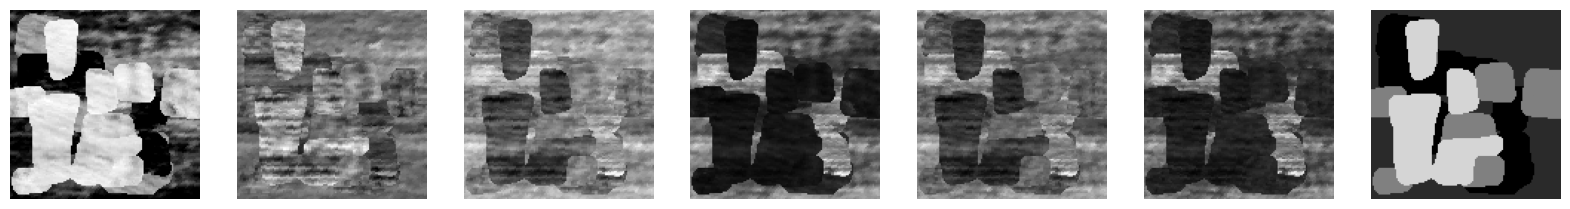

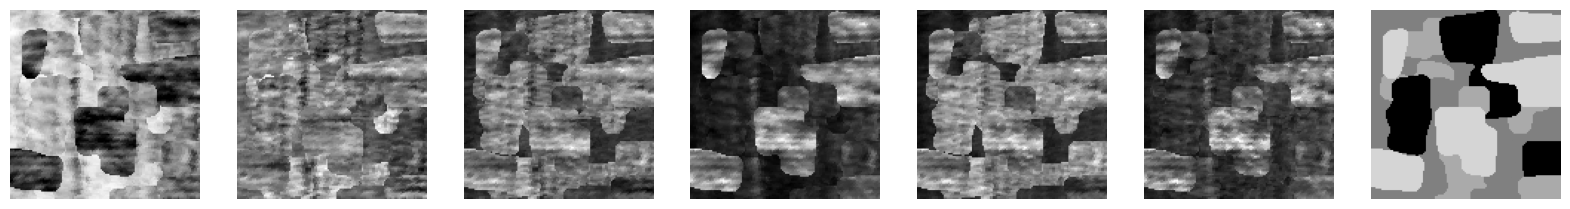

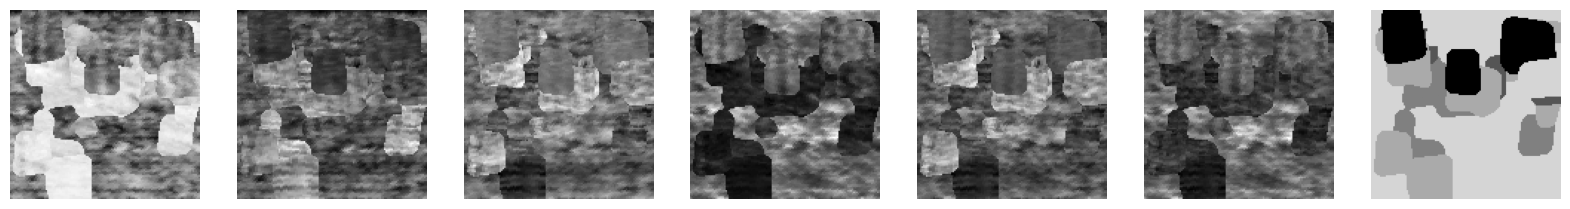

In [ ]:
# for i in range(3):

#   img = X[i]
#   mask = y[i]
#   fig, ax = plt.subplots(1, 7, figsize=(20, 5))
#   for i in range(6):
#     ax[i].imshow(img[i], cmap='gray')
#     ax[i].axis('Off')
#   ax[-1].imshow(mask, cmap='gray', vmin=0, vmax=6)
#   ax[-1].axis('Off')
#   plt.show()

In [ ]:
global UNIQUE_ID
UNIQUE_ID = 0

In [ ]:
def save_images_and_masks(images, masks, synth_dataset_dir):

    global UNIQUE_ID


    folders = ['NDVI', 'NearIR', 'RedEdge', 'RGB', 'Masks']
    for folder in folders:
        os.makedirs(os.path.join(synth_dataset_dir, folder), exist_ok=True)

    N = images.shape[0]

    for i in tqdm(range(N), total=N, desc='Saving images and masks'):

        ndvi_channel = images[i, 0]
        nearir_channel = images[i, 1]
        rededge_channel = images[i, 2]
        rgb_channels = images[i, 3:6]

        mask = masks[i]

        base_filename = f"{UNIQUE_ID}"

        ndvi_path = os.path.join(synth_dataset_dir, 'NDVI', f"{base_filename}.png")
        cv2.imwrite(ndvi_path, (ndvi_channel * 255).astype(np.uint8))

        nearir_path = os.path.join(synth_dataset_dir, 'NearIR', f"{base_filename}.png")
        cv2.imwrite(nearir_path, (nearir_channel * 255).astype(np.uint8))

        rededge_path = os.path.join(synth_dataset_dir, 'RedEdge', f"{base_filename}.png")
        cv2.imwrite(rededge_path, (rededge_channel * 255).astype(np.uint8))

        rgb_image = np.transpose(rgb_channels, (1, 2, 0))
        rgb_path = os.path.join(synth_dataset_dir, 'RGB', f"{base_filename}.png")
        cv2.imwrite(rgb_path, (rgb_image * 255).astype(np.uint8))

        mask_path = os.path.join(synth_dataset_dir, 'Masks', f"{base_filename}.png")
        cv2.imwrite(mask_path, (mask * 40).astype(np.uint8))

        UNIQUE_ID += 1

In [ ]:
save_images_and_masks(X, y, synth_dataset_dir)

Saving images and masks: 100%|██████████| 3000/3000 [03:42<00:00, 13.46it/s]


In [ ]:
save_images_and_masks(test_images_arr, test_masks_arr, test_dataset_dir)

Saving images and masks: 100%|██████████| 52/52 [00:03<00:00, 15.47it/s]


In [ ]:
s_images, s_masks = collect_data(synth_dataset_dir)

Collecting: 100%|██████████| 5000/5000 [00:00<00:00, 89009.84it/s]


In [ ]:
t_images, t_masks = collect_data(test_dataset_dir)

Collecting: 100%|██████████| 66/66 [00:00<00:00, 32939.56it/s]


In [ ]:
print(len(s_images), len(s_masks))
print(len(t_images), len(t_masks))

5000 5000
66 66


In [ ]:
s_images_arr, s_masks_arr = make_nparrays(s_images, s_masks)

Processing data:   1%|▏         | 64/5000 [00:51<1:05:54,  1.25it/s]


KeyboardInterrupt: 

In [ ]:
t_images_arr, t_masks_arr = make_nparrays(t_images, t_masks)

Processing data:  70%|██████▉   | 46/66 [00:50<00:21,  1.10s/it]


KeyboardInterrupt: 

In [ ]:
# print(s_images_arr.shape, s_masks_arr.shape)
print(t_images_arr.shape, t_masks_arr.shape)

(66, 128, 128, 5) (66, 128, 128, 1)


In [ ]:
np.savez("/content/drive/MyDrive/dataset/data/train_images_and_masks.npz", images_arr=s_images_arr, masks_arr=s_masks_arr)

NameError: name 's_images_arr' is not defined

In [ ]:
np.savez("/content/drive/MyDrive/dataset/data/test_images_and_masks.npz", images_arr=t_images_arr, masks_arr=t_masks_arr)

In [ ]:
train_loaded_data = np.load("/content/drive/MyDrive/dataset/data/train_images_and_masks_rededge.npz")
test_loaded_data = np.load("/content/drive/MyDrive/dataset/data/test_images_and_masks_rededge.npz")
train_loaded_images = train_loaded_data["images_arr"]
train_loaded_masks = train_loaded_data["masks_arr"]
test_loaded_images = test_loaded_data["images_arr"]
test_loaded_masks = test_loaded_data["masks_arr"]

print(train_loaded_images.shape)
print(train_loaded_masks.shape)
print(test_loaded_images.shape)
print(test_loaded_masks.shape)

(3000, 128, 128, 5)
(3000, 128, 128, 1)
(66, 128, 128, 5)
(66, 128, 128, 1)


In [ ]:
data_gen_args = dict(
    rotation_range=90,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    horizontal_flip=True
)

In [ ]:
train_loaded_images = train_loaded_images[:3000]
train_loaded_masks = train_loaded_masks[:3000]
X_train = train_loaded_images[:2900]
y_train = train_loaded_masks[:2900]
X_val = train_loaded_images[2900:]
y_val = train_loaded_masks[2900:]
X_test = test_loaded_images
y_test = test_loaded_masks
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2900, 128, 128, 5) (2900, 128, 128, 1)
(100, 128, 128, 5) (100, 128, 128, 1)
(66, 128, 128, 5) (66, 128, 128, 1)


In [ ]:
seed = 42
train_image_datagen = ImageDataGenerator(**data_gen_args)
train_mask_datagen = ImageDataGenerator(**data_gen_args)
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()
test_image_datagen = ImageDataGenerator()
test_mask_datagen = ImageDataGenerator()

In [ ]:
train_image_generator = train_image_datagen.flow(X_train, batch_size=32, seed=seed)
train_mask_generator = train_mask_datagen.flow(y_train, batch_size=32, seed=seed)
val_image_generator = val_image_datagen.flow(X_val, batch_size=32, seed=seed)
val_mask_generator = val_mask_datagen.flow(y_val, batch_size=32, seed=seed)
test_image_generator = test_image_datagen.flow(X_test, batch_size=32, shuffle=False, seed=seed)
test_mask_generator = test_mask_datagen.flow(y_test, batch_size=32, shuffle=False, seed=seed)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2900, 128, 128, 5) (5 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (100, 128, 128, 5) (5 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (66, 128, 128, 5) (5 chann

In [ ]:
# train_image_generator = image_datagen.flow(s_images_arr, batch_size=32, seed=seed)
# train_mask_generator = mask_datagen.flow(s_masks_arr, batch_size=32, seed=seed)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3, 128, 128, 6) (6 channels).
  warnings.warn(


In [ ]:
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

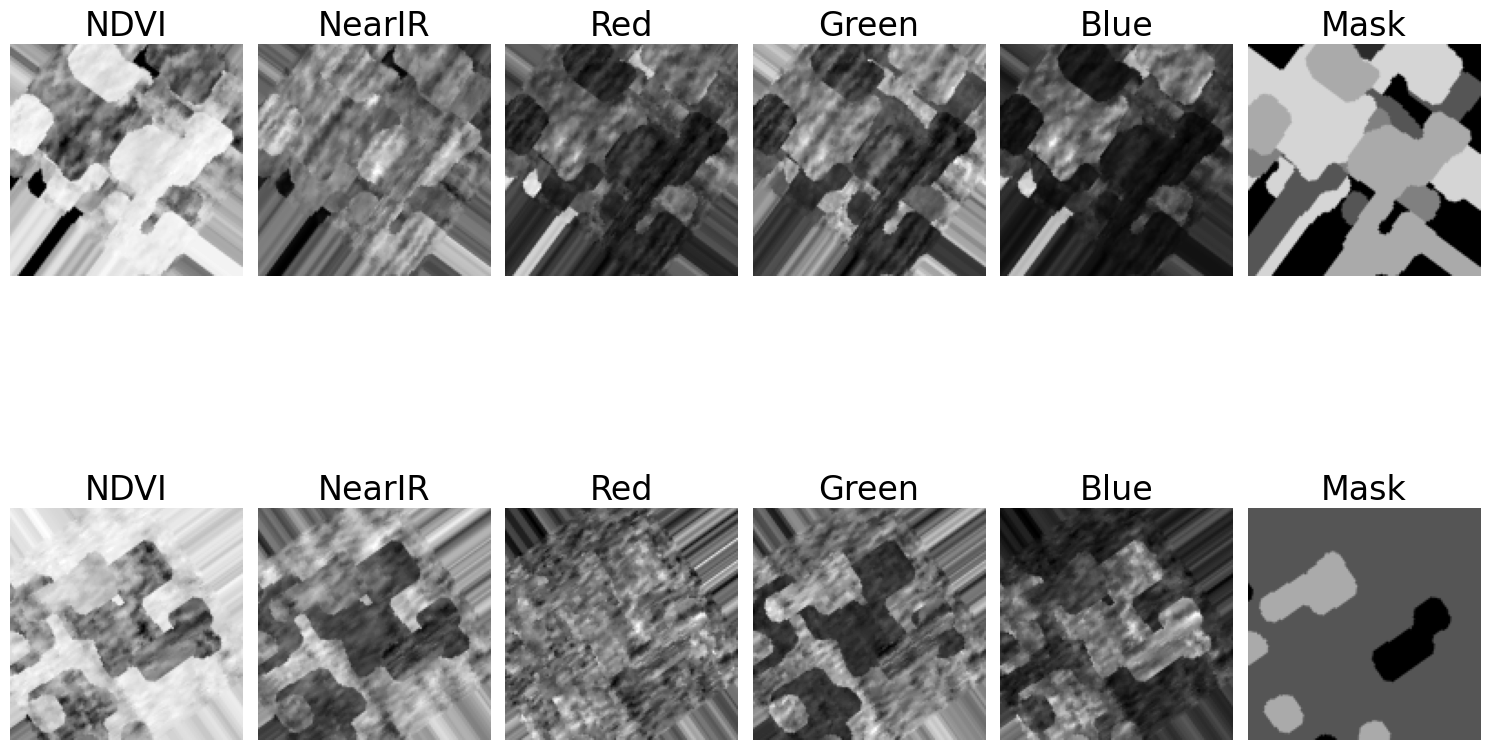

In [ ]:
# num_samples_to_plot = 2
# image_batch, mask_batch = next(train_generator)
# channels = image_batch.shape[-1]  # Количество каналов в изображении (6)
# fig, axes = plt.subplots(num_samples_to_plot, channels + 1, figsize=(15, 5 * num_samples_to_plot))

# channels_names = ['NDVI', 'NearIR', 'Red', 'Green', 'Blue']

# for i in range(num_samples_to_plot):
#     for c in range(channels):
#         # Отображаем каждый канал изображения
#         axes[i, c].imshow(image_batch[i, :, :, c], cmap='gray')
#         axes[i, c].axis('off')
#         axes[i, c].set_title(f"{channels_names[c]}", fontsize=24)

#     # Отображаем соответствующую маску (последний столбец)
#     axes[i, -1].imshow(mask_batch[i].squeeze(), cmap='gray', vmin=0, vmax=6)  # squeeze() убирает размерность (128, 128, 1) -> (128, 128)
#     axes[i, -1].axis('off')
#     axes[i, -1].set_title(f"Mask", fontsize=24)

# plt.tight_layout()
# plt.subplots_adjust(top=0.9, hspace=0.1)
# plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**U-Net**

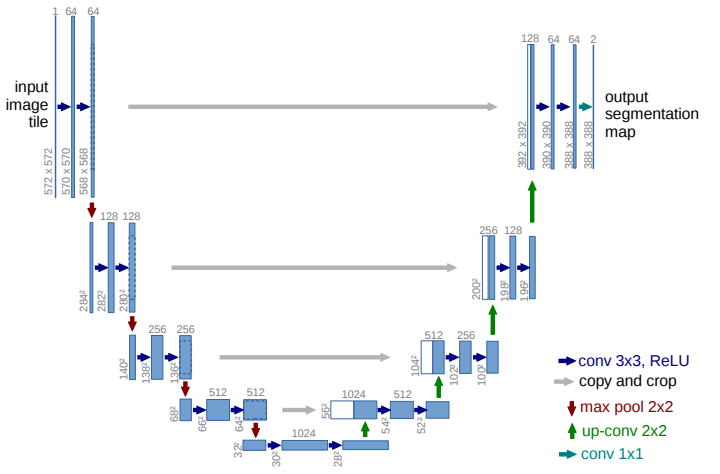

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)

In [ ]:
class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):

    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)

      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

In [ ]:
def test():
  x = torch.randn((3, 1, 161, 161))
  model = UNet(in_channels=1, out_channels=1)
  preds = model(x)
  assert preds.shape == x.shape

test()

In [ ]:
def train(model, opt, loss_fn, epochs, train_generator, val_generator, test_generator, steps_per_epoch, val_steps, test_steps):
  train_losses = []
  val_losses = []
  test_losses = []
  train_ious = []
  val_ious = []
  test_ious = []

  train_iou_metric = JaccardIndex(task="multiclass", num_classes=6).to(device)
  val_iou_metric = JaccardIndex(task="multiclass", num_classes=6).to(device)
  test_iou_metric = JaccardIndex(task="multiclass", num_classes=6).to(device)

  scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, verbose=True)

  X_vis, y_vis = next(val_generator)
  X_vis, y_vis = torch.tensor(X_vis), torch.tensor(y_vis)
  X_vis = X_vis.permute(0, 3, 1, 2)
  y_vis = y_vis.squeeze(dim=3)

  for epoch in range(epochs):
    print('Epoch %d/%d' % (epoch+1, epochs))
    avg_loss = 0
    model.train()
    train_iou_metric.reset()

    for step in tqdm(range(steps_per_epoch), desc='Training'):
      X_batch, y_batch = next(train_generator)
      X_batch = torch.tensor(X_batch).permute(0, 3, 1, 2).to(device)
      y_batch = torch.tensor(y_batch).squeeze(dim=3).to(device)
      y_batch = y_batch.long()
      opt.zero_grad()
      y_pred = model(X_batch)
      loss = loss_fn(y_pred, y_batch)
      loss.backward()
      opt.step()
      avg_loss += loss.item() / steps_per_epoch
      preds = torch.argmax(y_pred, dim=1)
      train_iou_metric.update(preds, y_batch)

    train_losses.append(avg_loss)
    train_ious.append(train_iou_metric.compute().item())
    print('Average train loss: %f | Train IoU: %f' % (avg_loss, train_ious[-1]))

    model.eval()
    val_loss = 0
    val_iou_metric.reset()
    with torch.no_grad():
      for step in range(val_steps):
        X_val, y_val = next(val_generator)
        X_val = torch.tensor(X_val).permute(0, 3, 1, 2).to(device)
        y_val = torch.tensor(y_val).squeeze(dim=3).to(device)
        y_val = y_val.long()
        y_pred = model(X_val)
        val_loss += loss_fn(y_pred, y_val).item() / val_steps
        y_pred_iou = torch.argmax(y_pred, dim=1)
        for_metric = [y_pred, y_pred_iou, y_val]
        val_iou_metric.update(y_pred_iou, y_val)

    val_losses.append(val_loss)
    val_ious.append(val_iou_metric.compute().item())

    print('Validation loss: %f | Validation IoU: %f' % (val_loss, val_ious[-1]))

    scheduler.step(val_loss)

    model.eval()
    test_loss = 0
    test_iou_metric.reset()
    with torch.no_grad():
      for step in range(test_steps):
        X_test, y_test = next(test_generator)
        X_test = torch.tensor(X_test).permute(0, 3, 1, 2).to(device)
        y_test = torch.tensor(y_test).squeeze(dim=3).to(device)
        y_test = y_test.long()
        y_pred = model(X_test)
        test_loss += loss_fn(y_pred, y_test).item() / test_steps
        y_pred_iou = torch.argmax(y_pred, dim=1)
        test_iou_metric.update(y_pred_iou, y_test)

    test_losses.append(test_loss)
    test_ious.append(test_iou_metric.compute().item())

    print('Test loss: %f | Test IoU: %f' % (test_loss, test_ious[-1]))

    X_vis = X_vis.to(device)
    y_vis = y_vis.to(device)
    y_vis = y_vis.long()

    with torch.no_grad():
      y_pred_vis = model(X_vis)
      y_pred_vis = torch.argmax(y_pred_vis, dim=1).cpu()

    X_vis = X_vis.cpu()
    y_vis = y_vis.cpu()

    clear_output(wait=True)
    fig, ax = plt.subplots(3, 6, figsize=(9, 6))
    fig.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, val_loss))

    for i in range(6):

      img = X_vis[i][0].numpy()

      ax[0, i].imshow(img, cmap='gray')
      ax[0, i].axis('Off')
      ax[0, i].set_title('Input')

      ax[1, i].imshow(y_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
      ax[1, i].axis('Off')
      ax[1, i].set_title('Real mask')

      ax[2, i].imshow(y_pred_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
      ax[2, i].axis('Off')
      ax[2, i].set_title('Predicted mask')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train loss')
  plt.plot(val_losses, label='Validation loss')
  plt.plot(test_losses, label='Test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss')

  plt.subplot(1, 2, 2)
  plt.plot(train_ious, label='Train IoU')
  plt.plot(val_ious, label='Validation IoU')
  plt.plot(test_ious, label='Test IoU')
  plt.xlabel('Epochs')
  plt.ylabel('IoU')
  plt.legend()
  plt.title('IoU')

  plt.tight_layout()
  plt.show()

  return for_metric, train_losses, val_losses, test_losses, train_ious, val_ious, test_ious

In [ ]:
def evaluate_on_test(model, loss_fn, test_generator, test_steps):
  test_iou_metric = JaccardIndex(task="multiclass", num_classes=6).to(device)
  model.eval()
  test_loss = 0
  test_iou_metric.reset()
  with torch.no_grad():
    for step in range(test_steps):
      X_test, y_test = next(test_generator)
      X_test = torch.tensor(X_test).permute(0, 3, 1, 2).to(device)
      y_test = torch.tensor(y_test).squeeze(dim=3).to(device)
      y_test = y_test.long()
      y_pred = model(X_test)
      y_pred_iou = torch.argmax(y_pred, dim=1)
      test_iou_metric.update(y_pred_iou, y_test)

  X_vis, y_vis = next(test_generator)
  X_vis = torch.tensor(X_vis).permute(0, 3, 1, 2).to(device)
  y_vis = torch.tensor(y_vis).squeeze(dim=3).to(device)
  y_vis = y_vis.long()

  with torch.no_grad():
    y_pred_vis = model(X_vis)
    y_pred_vis = torch.argmax(y_pred_vis, dim=1).cpu()

  X_vis = X_vis.cpu()
  y_vis = y_vis.cpu()

  clear_output(wait=True)
  fig, ax = plt.subplots(3, 6, figsize=(9, 6))

  for i in range(6):

    img = X_vis[i][0].numpy()

    ax[0, i].imshow(img, cmap='gray')
    ax[0, i].axis('Off')
    ax[0, i].set_title('Input')

    ax[1, i].imshow(y_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
    ax[1, i].axis('Off')
    ax[1, i].set_title('Real mask')

    ax[2, i].imshow(y_pred_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
    ax[2, i].axis('Off')
    ax[2, i].set_title('Predicted mask')

  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()

  test_accuracy = test_iou_metric.compute().item()
  print('Test Accuracy: %f' % test_accuracy)
  return test_accuracy

In [ ]:
steps_per_epoch = math.ceil(X_train.shape[0] / 32)
val_steps = math.ceil(X_val.shape[0] / 32)
test_steps = math.ceil(X_test.shape[0] / 32)
steps_per_epoch, val_steps, test_steps

(91, 4, 3)

In [ ]:
model = UNet(in_channels=5, out_channels=6).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()
max_epochs = 50

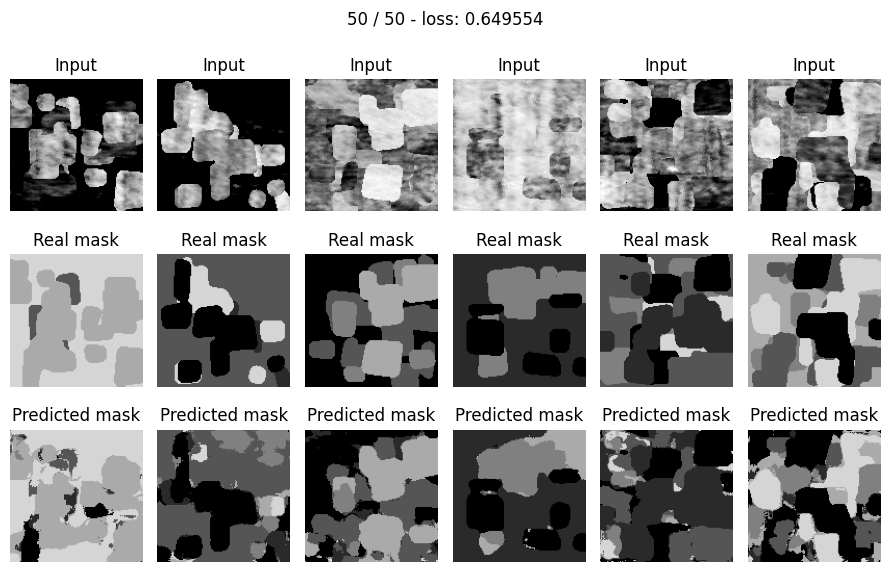

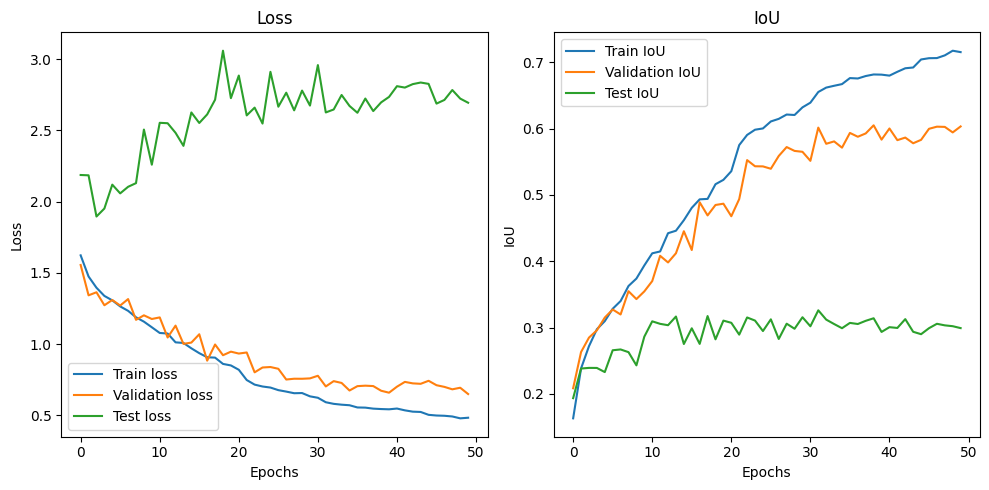

In [ ]:
tests = train(model, opt, loss, max_epochs, train_generator, val_generator, test_generator, steps_per_epoch, val_steps, test_steps)

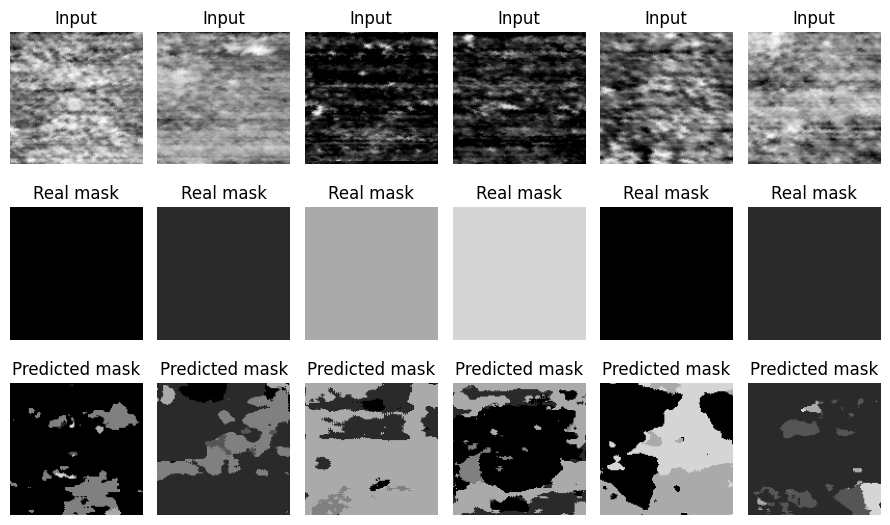

Test Accuracy: 0.299152


In [ ]:
test = evaluate_on_test(model, loss, test_generator, test_steps)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

def compute_metrics(y_val, y_pred, num_classes=5):
    """
    Вычисление метрик accuracy, balanced_accuracy, f1-score и IoU для массивов масок.

    Args:
        y_val (np.ndarray): Истинные маски (размерность: [N, H, W]).
        y_pred (np.ndarray): Предсказанные маски (размерность: [N, H, W]).
        num_classes (int, optional): Число классов (если не указано, будет определено автоматически).

    Returns:
        dict: Словарь с метриками.
    """
    # Проверка входных данных
    assert y_val.shape == y_pred.shape, "Размерности y_val и y_pred должны совпадать"

    # Flatten маски для обработки в формате [N * H * W]
    y_val_flat = y_val.flatten()
    y_pred_flat = y_pred.flatten()

    # Если число классов не задано, определяем его
    if num_classes is None:
        num_classes = max(np.max(y_val_flat), np.max(y_pred_flat)) + 1

    # Accuracy
    acc = accuracy_score(y_val_flat, y_pred_flat)

    # Balanced Accuracy
    bal_acc = balanced_accuracy_score(y_val_flat, y_pred_flat)

    # F1-Score
    f1 = f1_score(y_val_flat, y_pred_flat, average='weighted')

    # IoU для каждого класса
    iou_per_class = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_val_flat == cls, y_pred_flat == cls).sum()
        union = np.logical_or(y_val_flat == cls, y_pred_flat == cls).sum()
        iou = intersection / union if union > 0 else 0.0
        iou_per_class.append(iou)

    # Средний IoU по всем классам
    mean_iou = np.mean(iou_per_class)

    return {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'iou_per_class': iou_per_class,
        'mean_iou': mean_iou
    }

In [ ]:
y_metrics = tests[0]
y_pred = y_metrics[1].cpu()
y_real = y_metrics[2].cpu()
y_pred.shape, y_real.shape

In [ ]:
res = compute_metrics(y_real, y_pred)

In [ ]:
res

{'accuracy': 0.7547721862792969,
 'balanced_accuracy': 0.7648253178405993,
 'f1_score': 0.7522400142072752,
 'iou_per_class': [tensor(0.7360),
  tensor(0.6495),
  tensor(0.6432),
  tensor(0.5470),
  tensor(0.5483)],
 'mean_iou': 0.62482274}

1000 images, 10 epochs
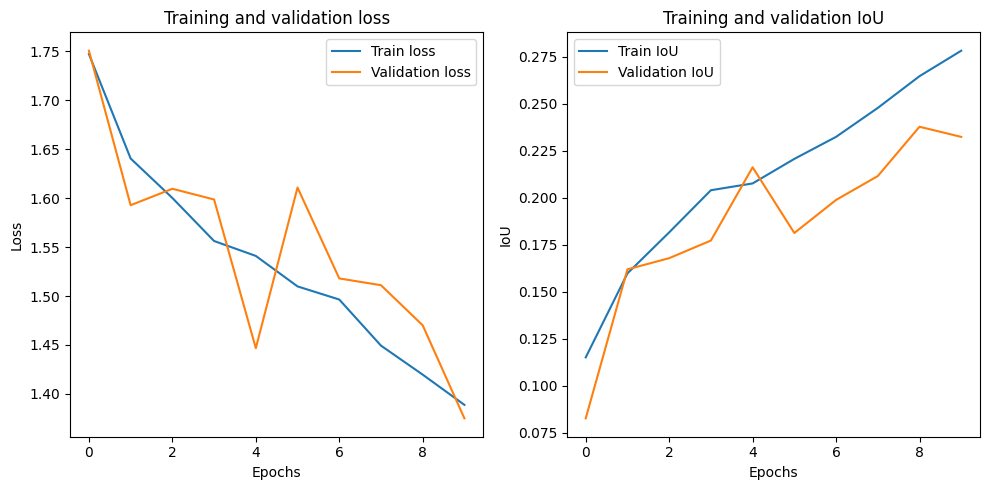

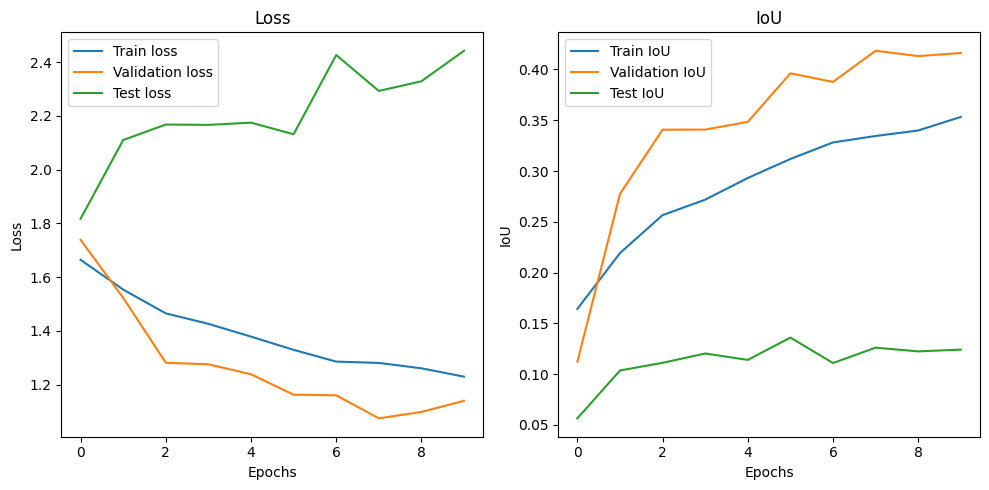

1000 images 30 epochs
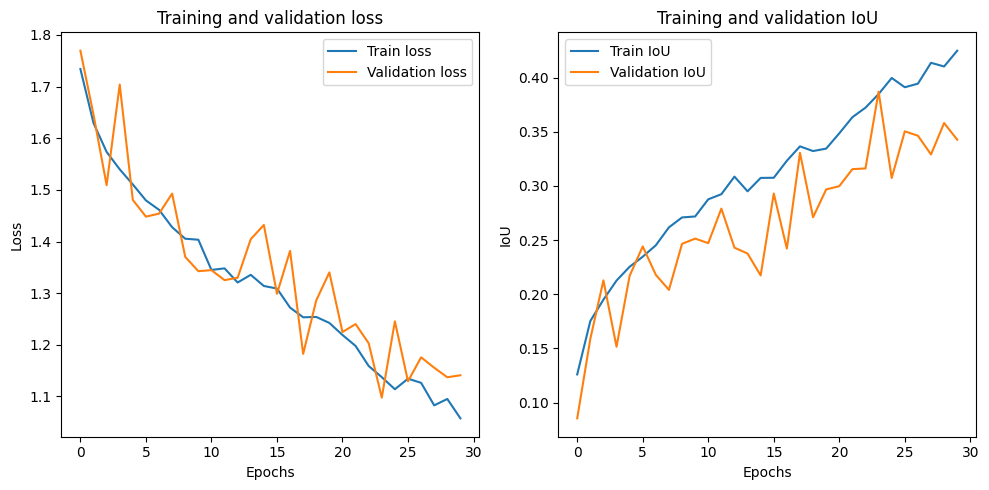

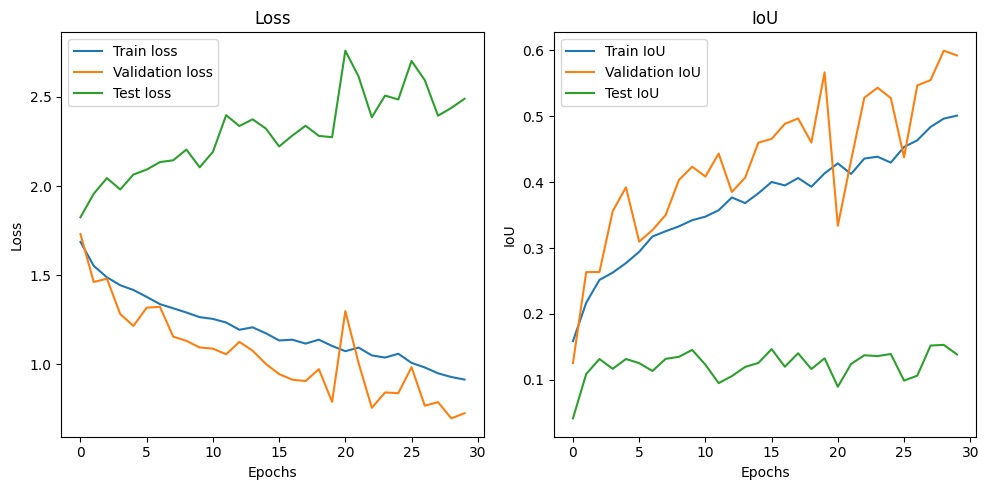

3000 images 10 epochs
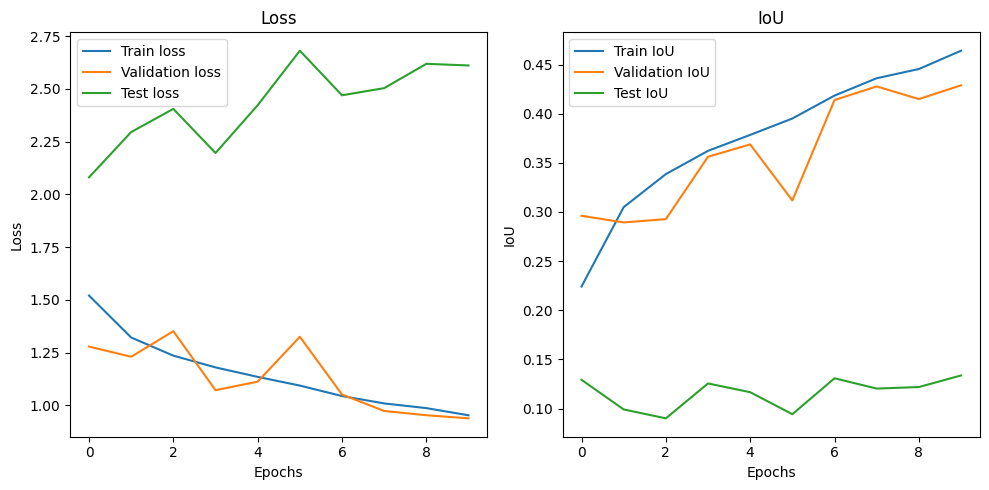

3000 images 30 epochs
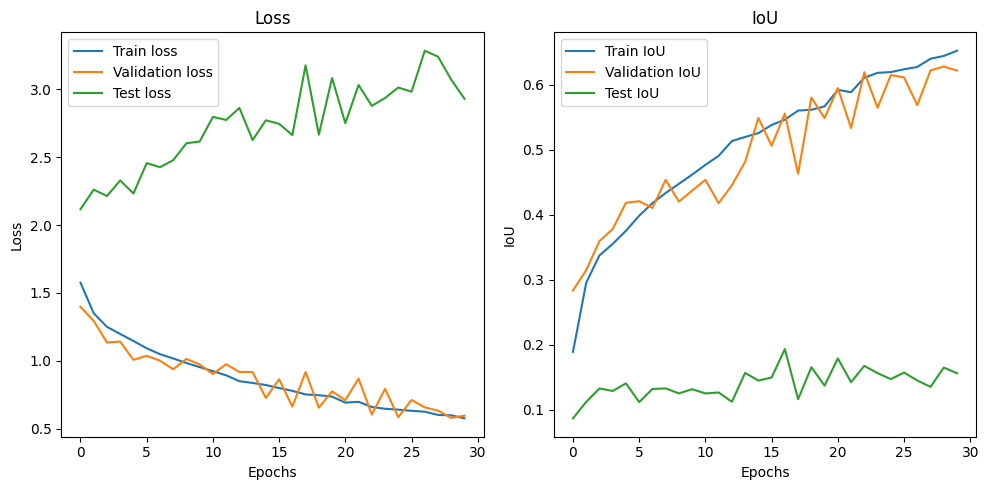

**U-Net++**

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class Up(nn.Module):
    """Upscaling and concat"""

    def __init__(self):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return x


class NestedUNet(nn.Module):
    def __init__(self, num_classes=1, input_channels=1, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = Up()

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(self.up(x1_0, x0_0))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(self.up(x2_0, x1_0))
        x0_2 = self.conv0_2(self.up(x1_1, torch.cat([x0_0, x0_1], 1)))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(self.up(x3_0, x2_0))
        x1_2 = self.conv1_2(self.up(x2_1, torch.cat([x1_0, x1_1], 1)))
        x0_3 = self.conv0_3(self.up(x1_2, torch.cat([x0_0, x0_1, x0_2], 1)))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(self.up(x4_0, x3_0))
        x2_2 = self.conv2_2(self.up(x3_1, torch.cat([x2_0, x2_1], 1)))
        x1_3 = self.conv1_3(self.up(x2_2, torch.cat([x1_0, x1_1, x1_2], 1)))
        x0_4 = self.conv0_4(self.up(x1_3, torch.cat([x0_0, x0_1, x0_2, x0_3], 1)))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [ ]:
def test_model():
    # Параметры теста
    batch_size = 4
    input_channels = 5
    height, width = 128, 128
    num_classes = 6
    deep_supervision = False  # или False

    # Создание случайного входного тензора
    input_tensor = torch.randn(batch_size, input_channels, height, width)

    # Создание модели
    model = NestedUNet(num_classes=num_classes, input_channels=input_channels, deep_supervision=deep_supervision)

    # Прогон через модель
    output = model(input_tensor)

    # Если используется глубокий надзор, должны быть несколько выходов
    if deep_supervision:
        print(f'Количество выходов: {len(output)}')
        for i, out in enumerate(output):
            print(f'Размер выходных данных {i+1}: {out.size()}')
    else:
        print(f'Размер выходных данных: {output.size()}')

In [ ]:
test_model()

Размер выходных данных: torch.Size([4, 6, 128, 128])


In [ ]:
model = NestedUNet(num_classes=6, input_channels=5).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()
max_epochs = 50

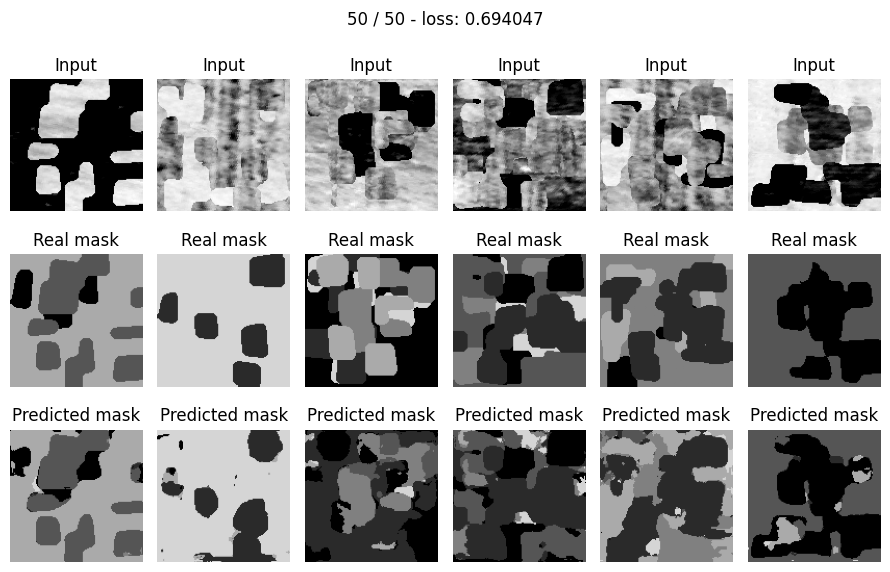

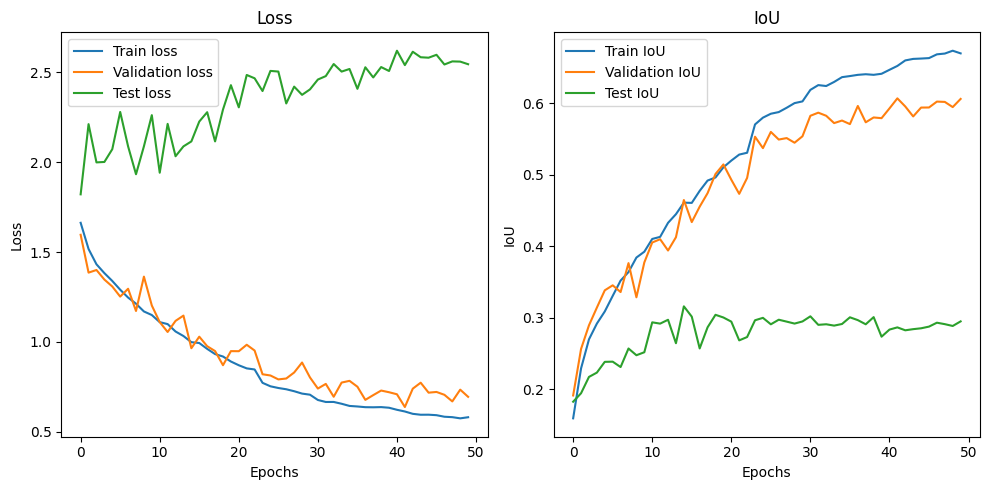

In [ ]:
tests = train(model, opt, loss, max_epochs, train_generator, val_generator, test_generator, steps_per_epoch, val_steps, test_steps)

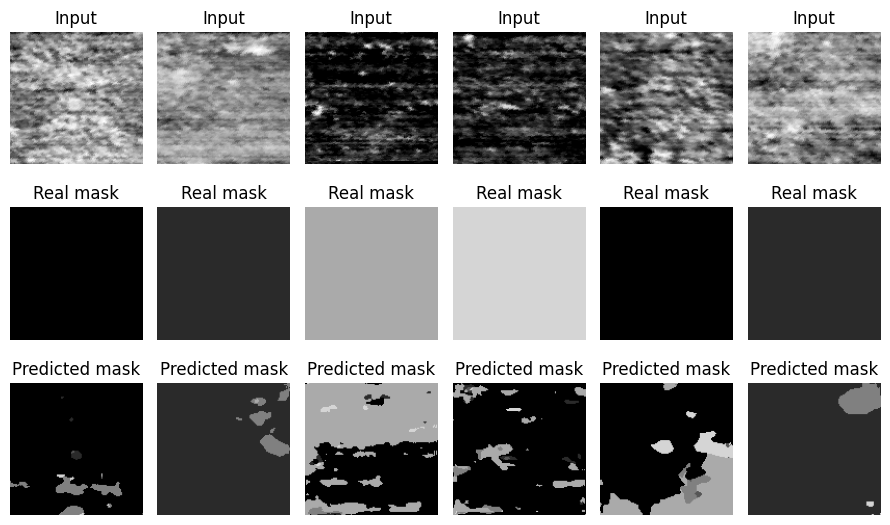

Test Accuracy: 0.294837


In [ ]:
test = evaluate_on_test(model, loss, test_generator, test_steps)

In [ ]:
y_metrics = tests[0]
y_pred = y_metrics[1].cpu()
y_real = y_metrics[2].cpu()
y_pred.shape, y_real.shape

(torch.Size([32, 128, 128]), torch.Size([32, 128, 128]))

In [ ]:
res = compute_metrics(y_real, y_pred)
res

{'accuracy': 0.7524375915527344,
 'balanced_accuracy': 0.7520315885027488,
 'f1_score': 0.7514934595650541,
 'iou_per_class': [tensor(0.7126),
  tensor(0.5904),
  tensor(0.6188),
  tensor(0.5654),
  tensor(0.5831)],
 'mean_iou': 0.6140499}

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_channels):
        super(Encoder, self).__init__()

        self.enco1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enco2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enco3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.enco4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.enco5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

    def forward(self, x):
        id = []
        x = self.enco1(x)
        x, id1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id1)
        x = self.enco2(x)
        x, id2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id2)
        x = self.enco3(x)
        x, id3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id3)
        x = self.enco4(x)
        x, id4 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id4)
        x = self.enco5(x)
        x, id5 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id5)
        return x, id

class SegNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SegNet, self).__init__()

        self.encoder = Encoder(input_channels)

        self.deco1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.deco2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deco3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deco4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.deco5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x, id = self.encoder(x)
        x = F.max_unpool2d(x, id[4], kernel_size=2, stride=2)
        x = self.deco1(x)
        x = F.max_unpool2d(x, id[3], kernel_size=2, stride=2)
        x = self.deco2(x)
        x = F.max_unpool2d(x, id[2], kernel_size=2, stride=2)
        x = self.deco3(x)
        x = F.max_unpool2d(x, id[1], kernel_size=2, stride=2)
        x = self.deco4(x)
        x = F.max_unpool2d(x, id[0], kernel_size=2, stride=2)
        x = self.deco5(x)

        return x

In [ ]:
def test_model():
    # Создаем случайный 5-канальный входной тензор (например, 256x256 изображения)
    input_tensor = torch.randn(4, 5, 256, 256)  # 4 - батч, 5 - каналы, 256x256 - размер изображения
    model = SegNet(input_channels=5, output_channels=6)  # 6 классов на выходе

    # Прогоняем модель через тестовые данные
    output = model(input_tensor)

    # Выводим размерность результата
    print(f"Размер выходных данных: {output.shape}")

In [ ]:
test_model()

Размер выходных данных: torch.Size([4, 6, 256, 256])


In [ ]:
model = SegNet(input_channels=5, output_channels=6).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()
max_epochs = 50

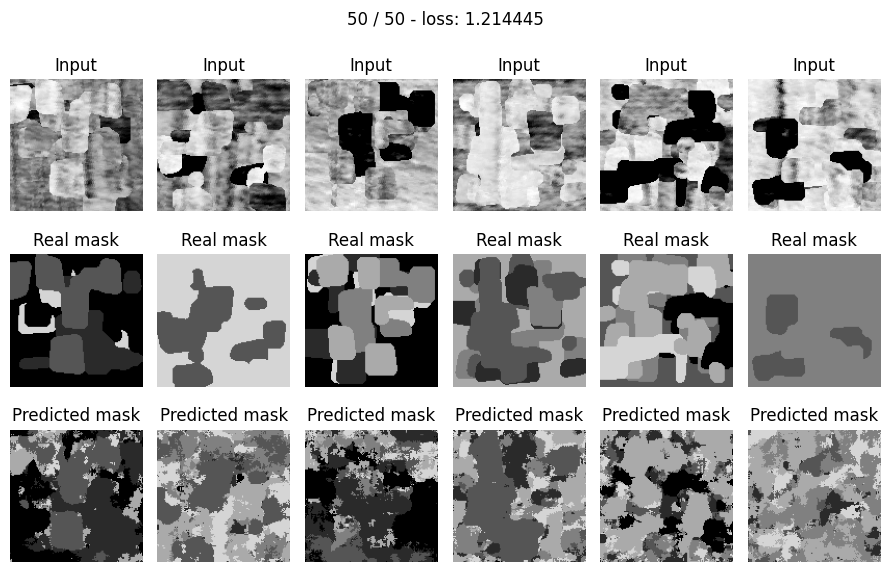

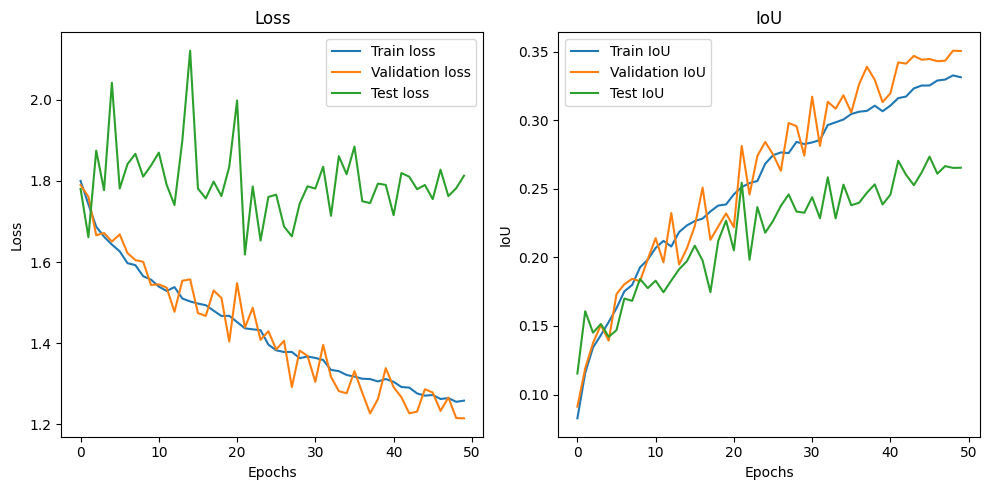

In [ ]:
tests = train(model, opt, loss, max_epochs, train_generator, val_generator, test_generator, steps_per_epoch, val_steps, test_steps)

In [ ]:
y_metrics = tests[0]
y_pred = y_metrics[1].cpu()
y_real = y_metrics[2].cpu()
y_pred.shape, y_real.shape

(torch.Size([32, 128, 128]), torch.Size([32, 128, 128]))

In [ ]:
res = compute_metrics(y_real, y_pred)
res

{'accuracy': 0.5272274017333984,
 'balanced_accuracy': 0.5019855080431951,
 'f1_score': 0.5211473893648817,
 'iou_per_class': [tensor(0.5894),
  tensor(0.4551),
  tensor(0.2598),
  tensor(0.2084),
  tensor(0.2898)],
 'mean_iou': 0.36049947}